# Set up

In [1]:
import calendar
import dask
from datetime import datetime, timedelta
import exactextract as ee
from exactextract import exact_extract
import gc
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import rioxarray as rxr
from shapely.geometry import mapping, shape
from shapely.geometry import mapping, Point
from scipy.spatial import cKDTree
import time 
from tqdm import tqdm
import xarray as xr
import math
from pathlib import Path

p = Path("/media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024")

# Extraction buffer

In [41]:
from datetime import datetime

def yearweek_to_datetime(yw: int) -> datetime:
    """
    Convert an integer like 201801 → datetime for Monday of that week.

    First tries ISO year-week (fromisocalendar). If the combination is invalid
    (e.g. year 2024 week 53), falls back to:
        Jan 1 of year + (week-1)*7 days
    """
    year = yw // 100
    week = yw % 100

    try:
        return datetime.fromisocalendar(year, week, 1)  # Monday
    except ValueError:
        base = datetime(year, 1, 1)
        return base + timedelta(weeks=week - 1)

















def compute_density_from_2d_raster(raster_2d, shape_geometry, polygon_area_m2):
    """
    raster_2d: 2D xarray DataArray (with rioxarray spatial metadata, dims y/x)
               representing the SUM over the 4 weeks.
    shape_geometry: shapely geometry
    polygon_area_m2: area of the polygon in m² (EPSG:3857)

    Returns: density = (sum of pixel values in polygon) / polygon_area_km2
             units: boats per km²
             or None if no valid pixels.
    """
    try:
        if polygon_area_m2 is None or polygon_area_m2 <= 0:
            return None

        feature = {"type": "Feature", "geometry": mapping(shape_geometry), "properties": {}}
        res = exact_extract(raster_2d, [feature], ["sum"])

        if not res or len(res) == 0:
            return None

        props = res[0].get("properties", {}) or {}

        # collect numeric "sum" values (e.g. "band1_sum" or just "sum")
        sums = []
        for k, v in props.items():
            if k.endswith("_sum") or k == "sum":
                try:
                    f = float(v)
                    if math.isfinite(f):
                        sums.append(f)
                except (TypeError, ValueError):
                    continue

        if not sums:
            return None

        total_sum = float(np.nansum(sums))
        if not math.isfinite(total_sum):
            return None

        # convert area to km²
        area_km2 = polygon_area_m2 / 1_000_000.0
        if area_km2 <= 0:
            return None

        density = total_sum / area_km2   # boats per km²
        return density

    except Exception as e:
        print(f"compute_density_from_2d_raster ERROR: {e}")
        return None













  










def process_geojson_yearweek(
    geojson_path,
    netcdf_path,
    output_path,
    variable="__xarray_dataarray_variable__",
    xr_chunks=None,
    raster_crs="EPSG:3857",
):
    """
    For each polygon date, use the 4 preceding weeks (yearweek < date),
    compute temporal SUM over those 4 weeks, then sum of pixel values in the
    polygon and divide by polygon area to get a density.

    Output column:
      Boat_weekly_month_density
    """

    # 1. Read polygons (assumed input in EPSG:4326)
    shapes2 = gpd.read_file(geojson_path)
    shapes = shapes2.to_crs('EPSG:3857')
    # shapes = shapes.set_crs("EPSG:4326", allow_override=True)

    # Filter by region based on netcdf_path
    nc_lower = str(netcdf_path).lower()
    if "corse" in nc_lower:
        shapes = shapes[shapes["region"] == "Corse"]
    elif "metropole" in nc_lower:
        shapes = shapes[shapes["region"].isin(["Occitanie", "PACA"])]

    # Reproject polygons to raster CRS (meters, so area is in m²)
    shapes = shapes.to_crs(raster_crs)
    #shapes = shapes[0:200]  # your current subset; remove if you want all

    # 2. Open dataset with dask chunking
    if xr_chunks is None:
        xr_chunks = {"yearweek": 10}
    ds = xr.open_dataset(netcdf_path, chunks=xr_chunks)

    # 3. Build a proper DataArray with x/y dims and CRS
    da_all = ds[variable]
    da_all = da_all.rename({"lon": "x", "lat": "y"})
    da_all = da_all.rio.write_crs(raster_crs, inplace=False)
    da_all = da_all.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

    # 4. Build datetime coordinate for each yearweek
    yearweek_vals = ds["yearweek"].values
    week_start_dates = np.array(
        [np.datetime64(yearweek_to_datetime(int(yw))) for yw in yearweek_vals]
    )
    da_all = da_all.assign_coords(week_start=("yearweek", week_start_dates))

    # Numpy array for fast masking
    week_start_np = da_all["week_start"].values

    results = []
    total = shapes.shape[0]

    for _, row in tqdm(shapes.iterrows(), total=total, desc="Processing shapes (4 preceding weeks)"):
        shape_geometry = row.geometry
        date = row["date"]
        polygon_id = row.get("replicates", None)

        if isinstance(date, str):
            date = datetime.strptime(date, "%Y-%m-%d")

        result_entry = {"replicates": polygon_id}

        try:
            date64 = np.datetime64(date)

            # all weeks strictly before the sampling date
            mask_before = week_start_np < date64
            idx_before = np.where(mask_before)[0]

            if idx_before.size == 0:
                result_entry["Boat_weekly_month_density"] = None
                results.append(result_entry)
                continue

            # take the last 4 indices (most recent 4 weeks)
            idx_sel = idx_before[-4:]
            yw_sel = da_all["yearweek"].values[idx_sel]

            # slice to only those 4 weeks
            da_slice = da_all.sel(yearweek=yw_sel)

            # temporal SUM over the 4 weeks  -> 2D DataArray (y,x)
            da_sum = da_slice.sum(dim="yearweek", skipna=True)

            # compute aggregated 2D field
            da_sum_2d = da_sum.compute()

            # polygon area in m² (since EPSG:3857)
            area_m2 = shape_geometry.area

            # density = (sum of pixel values in polygon) / area
            density_val = compute_density_from_2d_raster(
                da_sum_2d, shape_geometry, area_m2
            )

            result_entry["Boat_density_month"] = density_val

        except Exception as e:
            print(f"Error for polygon {polygon_id}: {e}")
            result_entry["Boat_density_month"] = None

        finally:
            for v in ("da_slice", "da_sum", "da_sum_2d"):
                if v in locals():
                    try:
                        del locals()[v]
                    except Exception:
                        pass
            gc.collect()

        results.append(result_entry)

    try:
        ds.close()
    except Exception:
        pass
    gc.collect()

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)
    return results_df


In [42]:
geojson_path = p / Path("./data/processed_data/Mtdt/mtdt_7.gpkg")
netcdf_path = p / Path("./data/raw_data/predictors/Boats/BOATS_MED_2018_2024_Final/normalised_boats_corse_3857.nc")
# netcdf_path = "./data/raw_data/predictors/Boats/boats_med_2018_2024/metropole/boats_corse_100m.nc"
output_path = p / Path("./data/processed_data/predictors/Prediction_grid_v1.1/mtdt_7_boats_month_corse_grid-3857_.csv")
#output_path = "./data/processed_data/predictors/Prediction_grid_v1.1/mtdt_7_boats_month_metropole[200:].csv"

results_df = process_geojson_yearweek(
    geojson_path=geojson_path,
    netcdf_path=netcdf_path,
    output_path=output_path,
    variable="boat_to_sat_ratio"
)



Processing shapes (4 preceding weeks): 100%|██████████| 299/299 [01:23<00:00,  3.59it/s]


In [61]:
# TESTS
mport scipy.stats
t4326 = pd.read_csv("/media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/mtdt_7_boats_month_corse.csv")
t3857 = pd.read_csv("/media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/mtdt_7_boats_month_corse_grid-3857_.csv")
scipy.stats.pearsonr(t4326["Boat_density_month"], t3857["Boat_density_month"])


# Conclusion = same results when we set the grid crs to 4326 than when we transform it to 3857
# Conclusion from test with setting ncdf to 3857, same results as when leaving it without crs (see R results)

PearsonRResult(statistic=1.0, pvalue=0.0)

In [60]:
t3857["Boat_density_month"]
# t4326["Boat_density_month"]

0      0.426232
1      0.143478
2      0.181044
3      0.000000
4      1.241669
         ...   
294    1.378252
295    0.812871
296    0.661349
297    0.000000
298    0.000000
Name: Boat_density_month, Length: 299, dtype: float64

In [7]:
geojson_path = "./data/processed_data/Mtdt/mtdt_7.gpkg"
netcdf_path = "./data/raw_data/predictors/Boats/BOATS_MED_2018_2024_Final/normalised_boats_metropole_3857.nc"
# netcdf_path = "./data/raw_data/predictors/Boats/boats_med_2018_2024/metropole/boats_corse_100m.nc"
output_path = "./data/processed_data/predictors/Prediction_grid_v1.1/mtdt_7_boats_month_metropole_3857.csv"
#output_path = "./data/processed_data/predictors/Prediction_grid_v1.1/mtdt_7_boats_month_metropole[200:].csv"

results_df = process_geojson_yearweek(
    geojson_path=geojson_path,
    netcdf_path=netcdf_path,
    output_path=output_path,
    variable="boat_to_sat_ratio"
)

Processing shapes (4 preceding weeks): 100%|██| 463/463 [02:05<00:00,  3.69it/s]


In [4]:
# Extraction buffer Corse - Metropole : Merge files together

import pandas as pd

# Paths to your 3 partial results
f1 = "./data/processed_data/predictors/Boats/mtdt_7_boats_month_corse.csv"
f2 = "./data/processed_data/predictors/Boats/mtdt_7_boats_month_metropole[0:200].csv"
f3 = "./data/processed_data/predictors/Boats/mtdt_7_boats_month_metropole[200:].csv"

# Load each
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

# Concatenate
merged = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

# Optional: remove duplicates if any
merged = merged.drop_duplicates(subset=["replicates"], keep="first")

# Optional: sort by replicates or by date
# merged = merged.sort_values("replicates")

# Save single merged file
out = "./data/processed_data/predictors//Boats/mtdt_7_boats_month_ALL.csv"
merged.to_csv(out, index=False)

print("Merged file written to:", out)
print("Number of rows:", len(merged))



FileNotFoundError: [Errno 2] No such file or directory: '/media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Boats/mtdt_7_boats_month_corse.csv'

# Extraction on grid

#### Function 

In [4]:
import math
import gc
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray  # noqa: F401  (needed for .rio accessor)
from shapely.geometry import mapping
from exactextract import exact_extract
from tqdm import tqdm


# --------------------------------------------------------------------------
# Helper: normalize date columns from GPKG (X2023.05.01 -> 2023-05-01)
# --------------------------------------------------------------------------
def normalize_date_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Rename GPKG-style date columns such as 'X2023.05.01' to '2023-05-01'.

    This is useful because GDAL often renames fields that start with a digit
    or contain special characters when writing/reading GeoPackages.
    """
    rename_map = {}

    for col in gdf.columns:
        # Typical pattern from GPKG: X2023.05.01, X2023.06.01, ...
        if col.startswith("X20") and "." in col:
            # Remove leading 'X' and replace '.' with '-'
            # 'X2023.09.01' -> '2023-09-01'
            date_str = col[1:].replace(".", "-")
            rename_map[col] = date_str

    if rename_map:
        gdf = gdf.rename(columns=rename_map)

    return gdf


# --------------------------------------------------------------------------
# Date utilities
# --------------------------------------------------------------------------
def yearweek_to_datetime(yw: int) -> datetime:
    """
    Convert an integer like 201801 → datetime for Monday of that week.

    First tries ISO year-week (fromisocalendar). If the combination is invalid
    (e.g. year 2024 week 53), falls back to:
        Jan 1 of year + (week-1)*7 days
    """
    year = yw // 100
    week = yw % 100

    try:
        return datetime.fromisocalendar(year, week, 1)  # Monday
    except ValueError:
        base = datetime(year, 1, 1)
        return base + timedelta(weeks=week - 1)


# --------------------------------------------------------------------------
# Density computation
# --------------------------------------------------------------------------
def compute_density_from_2d_raster(raster_2d, shape_geometry, polygon_area_m2):
    """
    raster_2d : 2D xarray.DataArray (SUM over the 4 weeks).
    shape_geometry : shapely geometry in same CRS as raster.
    polygon_area_m2 : area of the polygon in m².

    Returns:
        density = (sum of pixel values in polygon) / polygon_area_km2
        units: boats per km²
        or None if no valid pixels.
    """
    try:
        if polygon_area_m2 is None or polygon_area_m2 <= 0:
            return None

        feature = {
            "type": "Feature",
            "geometry": mapping(shape_geometry),
            "properties": {},
        }
        res = exact_extract(raster_2d, [feature], ["sum"])

        if not res or len(res) == 0:
            return None

        props = res[0].get("properties", {}) or {}

        sums = []
        for k, v in props.items():
            if k.endswith("_sum") or k == "sum":
                try:
                    f = float(v)
                    if math.isfinite(f):
                        sums.append(f)
                except (TypeError, ValueError):
                    continue

        # If everything is NaN / outside raster → no finite sums
        if not sums:
            return None

        total_sum = float(np.nansum(sums))
        if not math.isfinite(total_sum):
            return None

        area_km2 = polygon_area_m2 / 1_000_000.0
        if area_km2 <= 0:
            return None

        density = total_sum / area_km2  # boats per km²
        return density

    except Exception as e:
        print(f"compute_density_from_2d_raster ERROR: {e}")
        return None


# --------------------------------------------------------------------------
# Main processing per region & date
# --------------------------------------------------------------------------
def process_region_for_date(
    shapes_region_gdf,
    netcdf_path,
    date_col,
    variable_name="__xarray_dataarray_variable__",
    raster_crs="EPSG:3857",
    xr_chunks=None,
    chunk_size=500,
):
    """
    shapes_region_gdf: GeoDataFrame for a single region (e.g. 'corse', 'med-est'),
                       with at least columns ["id", date_col, "geometry", "region"].
    netcdf_path      : path to the boats NetCDF for this region.
    date_col         : column name with the sampling date (e.g. '2023-05-01').
    variable_name    : name of the data variable in the NetCDF.
    xr_chunks        : dict for xarray chunking (e.g. {"yearweek": 10}).
    chunk_size       : number of shapes to process per batch (used for the
                       progress bar only here).

    More memory-efficient:
    - groups polygons by the sampling date in `date_col`
    - for each date, computes the 4-week sum raster ONCE,
      then reuses it for all polygons with that sampling date.
    """

    # Defensive check: ensure the date column exists
    if date_col not in shapes_region_gdf.columns:
        raise KeyError(
            f"Column '{date_col}' not found in shapes_region_gdf. "
            f"Available columns: {list(shapes_region_gdf.columns)}"
        )

    # Reproject polygons to raster CRS (meters)
    shapes_region = shapes_region_gdf.to_crs(raster_crs).copy()

    # Open dataset with dask/xarray
    if xr_chunks is None:
        xr_chunks = {"yearweek": 10}
    ds = xr.open_dataset(netcdf_path, chunks=xr_chunks)

    da_all = ds[variable_name]
    da_all = da_all.rename({"lon": "x", "lat": "y"})
    da_all = da_all.rio.write_crs(raster_crs, inplace=False)
    da_all = da_all.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

    # Build datetime coordinate for each yearweek
    yearweek_vals = ds["yearweek"].values
    week_start_dates = np.array(
        [np.datetime64(yearweek_to_datetime(int(yw))) for yw in yearweek_vals]
    )
    da_all = da_all.assign_coords(week_start=("yearweek", week_start_dates))
    week_start_np = da_all["week_start"].values

    results = []

    # We’ll use the total number of polygons for the progress bar
    n_total = len(shapes_region)
    region_name = shapes_region["region"].iloc[0]

    with tqdm(total=n_total, desc=f"Region {region_name} - {date_col}") as pbar:

        # Group polygons by their sampling date in this column
        # (in case some polygons have different dates)
        for date_val, group in shapes_region.groupby(date_col):
            # Convert date to datetime
            if isinstance(date_val, str):
                date_dt = datetime.strptime(date_val, "%Y-%m-%d")
            else:
                date_dt = pd.to_datetime(date_val).to_pydatetime()

            try:
                date64 = np.datetime64(date_dt)

                # All weeks strictly before the sampling date
                mask_before = week_start_np < date64
                idx_before = np.where(mask_before)[0]

                if idx_before.size == 0:
                    # No weeks before this date: all densities are None
                    for _, row in group.iterrows():
                        results.append(
                            {"id": row["id"], "Boat_density_month": None}
                        )
                        pbar.update(1)
                    continue

                # Last 4 indices (most recent 4 weeks)
                idx_sel = idx_before[-4:]
                yw_sel = da_all["yearweek"].values[idx_sel]

                # Compute aggregated 2D raster ONCE for this date
                da_slice = da_all.sel(yearweek=yw_sel)
                da_sum = da_slice.sum(dim="yearweek", skipna=True)
                da_sum_2d = da_sum.compute()

                # Now loop over polygons with this sampling date
                for _, row in group.iterrows():
                    geom = row.geometry
                    area_m2 = geom.area

                    density_val = compute_density_from_2d_raster(
                        da_sum_2d, geom, area_m2
                    )

                    results.append(
                        {"id": row["id"], "Boat_density_month": density_val}
                    )
                    pbar.update(1)

            except Exception as e:
                print(f"Error for date {date_val} in region {region_name}: {e}")
                # Mark all in this group as None on error
                for _, row in group.iterrows():
                    results.append(
                        {"id": row["id"], "Boat_density_month": None}
                    )
                    pbar.update(1)

            finally:
                # Explicitly free big arrays
                for v in ("da_slice", "da_sum", "da_sum_2d"):
                    if v in locals():
                        try:
                            del locals()[v]
                        except Exception:
                            pass
                gc.collect()

    try:
        ds.close()
    except Exception:
        pass
    gc.collect()

    return pd.DataFrame(results)


#### Extract

In [6]:
import os
import geopandas as gpd
import pandas as pd

# -----------------------------------------------------------------------------
# Helper: normalize date columns from GPKG (X2023.05.01 -> 2023-05-01)
# -----------------------------------------------------------------------------
def normalize_date_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Rename GPKG-style date columns such as 'X2023.05.01' to '2023-05-01'.
    """
    rename_map = {}

    for col in gdf.columns:
        # Pattern from GPKG: X2023.05.01, X2023.06.01, ...
        if col.startswith("X20") and "." in col:
            # 'X2023.09.01' -> '2023-09-01'
            date_str = col[1:].replace(".", "-")
            rename_map[col] = date_str

    if rename_map:
        gdf = gdf.rename(columns=rename_map)

    return gdf


# -----------------------------------------------------------------------------
# Paths
# -----------------------------------------------------------------------------
shapes_path = p / Path("./data/processed_data/prediction_extent/grid_v1.1_3857.gpkg")
boats_corse_nc = p / Path("./data/raw_data/predictors/Boats/BOATS_MED_2018_2024_Final/normalised_boats_corse.nc")
boats_metropole_nc = p / Path("./data/raw_data/predictors/Boats/BOATS_MED_2018_2024_Final/normalised_boats_metropole.nc")
out_dir = p / Path("./data/processed_data/predictors/Prediction_grid_v1.1/")
per_region_dir = os.path.join(out_dir, "per_region_results")

os.makedirs(out_dir, exist_ok=True)
os.makedirs(per_region_dir, exist_ok=True)

# -----------------------------------------------------------------------------
# 1. Load full grid (this file looks like it's already in EPSG:3857)
# -----------------------------------------------------------------------------
gdf_all = gpd.read_file(shapes_path)
gdf_all = gdf_all.set_crs("EPSG:3857", allow_override=True)

# 🔹 Normalize the date columns here
gdf_all = normalize_date_columns(gdf_all)

print("Number of polygons in full grid:", len(gdf_all))
print("Columns after normalization:", list(gdf_all.columns))

# -----------------------------------------------------------------------------
# 2. Dates to process
# -----------------------------------------------------------------------------

date_cols = ["2023-05-01", "2023-06-01", "2023-07-01",
              "2023-08-01", "2023-09-01", "2023-10-01"]

# -----------------------------------------------------------------------------
# 3. Map region -> NetCDF
# -----------------------------------------------------------------------------
REGION_TO_NC = {
    "corse": boats_corse_nc,
    "med-est": boats_metropole_nc,
    "med-ouest": boats_metropole_nc
}

# -----------------------------------------------------------------------------
# 4. Loop over dates and process the full grid
# -----------------------------------------------------------------------------
for date_col in date_cols:
    print(f"\n=== Processing date column {date_col} on full grid ({len(gdf_all)} polygons) ===")

    per_region_results = []

    for region_label, nc_path in REGION_TO_NC.items():
        # Restrict to this region within the full grid
        subset_region = gdf_all[gdf_all["region"].str.lower() == region_label]

        if subset_region.empty:
            print(f"  - No polygons found for region '{region_label}' in this grid.")
            continue

        print(f"  - Region '{region_label}': {len(subset_region)} polygons")

        # --- CHECKPOINT FILE FOR THIS REGION + DATE ---
        checkpoint_file = os.path.join(
            per_region_dir, f"boats_{region_label}_{date_col}.parquet"
        )

        if os.path.exists(checkpoint_file):
            print(f"    -> Found existing checkpoint: {checkpoint_file}, loading instead of recomputing.")
            df_region = pd.read_parquet(checkpoint_file)
        else:
            # Compute from scratch
            df_region = process_region_for_date(
                shapes_region_gdf=subset_region,
                netcdf_path=nc_path,
                date_col=date_col,
                variable_name="boat_to_sat_ratio",
                raster_crs="EPSG:3857",   # same as grid + NetCDF
                xr_chunks={"yearweek": 10},
                chunk_size=50,
            )

            # Save checkpoint immediately
            df_region.to_parquet(checkpoint_file, index=False)
            print(f"    -> Saved checkpoint: {checkpoint_file}")

        per_region_results.append(df_region)

    if not per_region_results:
        print(f"No polygons to process for {date_col}, skipping.")
        continue

    # Concatenate all regions' results for this date
    df_results = pd.concat(per_region_results, axis=0, ignore_index=True)

    # Merge back into the full grid
    gdf_out = gdf_all.merge(df_results, on="id", how="left")

    # Rename the density column to be date-specific
    dens_col = f"Boat_density_month_{date_col}"
    gdf_out = gdf_out.rename(columns={"Boat_density_month": dens_col})

    # Save full-grid output for this date
    out_file = os.path.join(out_dir, f"Boats_month_{date_col}_full.geojson")
    gdf_out.to_file(out_file, driver="GeoJSON")

    print(f"Written full-grid file for {date_col}: {out_file}")
    print(gdf_out[["id", "region", dens_col]].head())


Number of polygons in full grid: 4423
Columns after normalization: ['id', 'value', 'region', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', 'depth_sampling_surface', 'depth_sampling_40m', 'geometry']

=== Processing date column 2023-05-01 on full grid (4423 polygons) ===
  - Region 'corse': 1472 polygons


Region corse - 2023-05-01: 100%|██████████| 1472/1472 [00:03<00:00, 403.18it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_corse_2023-05-01.parquet
  - Region 'med-est': 2608 polygons


Region med-est - 2023-05-01: 100%|██████████| 2608/2608 [00:06<00:00, 398.86it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_med-est_2023-05-01.parquet
Written full-grid file for 2023-05-01: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/Boats_month_2023-05-01_full.geojson
      id region  Boat_density_month_2023-05-01
0  20337  corse                       0.000000
1  20338  corse                       0.241246
2  20976  corse                       0.787648
3  20977  corse                       0.152676
4  21615  corse                       0.000000

=== Processing date column 2023-06-01 on full grid (4423 polygons) ===
  - Region 'corse': 1472 polygons


Region corse - 2023-06-01: 100%|██████████| 1472/1472 [00:03<00:00, 395.89it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_corse_2023-06-01.parquet
  - Region 'med-est': 2608 polygons


Region med-est - 2023-06-01: 100%|██████████| 2608/2608 [00:06<00:00, 388.33it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_med-est_2023-06-01.parquet
Written full-grid file for 2023-06-01: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/Boats_month_2023-06-01_full.geojson
      id region  Boat_density_month_2023-06-01
0  20337  corse                       0.000000
1  20338  corse                       0.364796
2  20976  corse                       0.019586
3  20977  corse                       0.403419
4  21615  corse                       0.196841

=== Processing date column 2023-07-01 on full grid (4423 polygons) ===
  - Region 'corse': 1472 polygons


Region corse - 2023-07-01: 100%|██████████| 1472/1472 [00:03<00:00, 387.95it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_corse_2023-07-01.parquet
  - Region 'med-est': 2608 polygons


Region med-est - 2023-07-01: 100%|██████████| 2608/2608 [00:06<00:00, 396.45it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_med-est_2023-07-01.parquet
Written full-grid file for 2023-07-01: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/Boats_month_2023-07-01_full.geojson
      id region  Boat_density_month_2023-07-01
0  20337  corse                       0.000000
1  20338  corse                       0.000000
2  20976  corse                       0.393824
3  20977  corse                       0.000000
4  21615  corse                       0.787365

=== Processing date column 2023-08-01 on full grid (4423 polygons) ===
  - Region 'corse': 1472 polygons


Region corse - 2023-08-01: 100%|██████████| 1472/1472 [00:03<00:00, 387.80it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_corse_2023-08-01.parquet
  - Region 'med-est': 2608 polygons


Region med-est - 2023-08-01: 100%|██████████| 2608/2608 [00:06<00:00, 403.80it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_med-est_2023-08-01.parquet
Written full-grid file for 2023-08-01: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/Boats_month_2023-08-01_full.geojson
      id region  Boat_density_month_2023-08-01
0  20337  corse                       0.393966
1  20338  corse                       0.000000
2  20976  corse                       0.984561
3  20977  corse                       0.393835
4  21615  corse                       0.629672

=== Processing date column 2023-09-01 on full grid (4423 polygons) ===
  - Region 'corse': 1472 polygons


Region corse - 2023-09-01: 100%|██████████| 1472/1472 [00:03<00:00, 400.43it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_corse_2023-09-01.parquet
  - Region 'med-est': 2608 polygons


Region med-est - 2023-09-01: 100%|██████████| 2608/2608 [00:06<00:00, 404.55it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_med-est_2023-09-01.parquet
Written full-grid file for 2023-09-01: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/Boats_month_2023-09-01_full.geojson
      id region  Boat_density_month_2023-09-01
0  20337  corse                       1.378880
1  20338  corse                       0.422372
2  20976  corse                       1.772209
3  20977  corse                       0.196918
4  21615  corse                       1.968413

=== Processing date column 2023-10-01 on full grid (4423 polygons) ===
  - Region 'corse': 1472 polygons


Region corse - 2023-10-01: 100%|██████████| 1472/1472 [00:03<00:00, 408.14it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_corse_2023-10-01.parquet
  - Region 'med-est': 2608 polygons


Region med-est - 2023-10-01: 100%|██████████| 2608/2608 [00:06<00:00, 400.96it/s]


    -> Saved checkpoint: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/per_region_results/boats_med-est_2023-10-01.parquet
Written full-grid file for 2023-10-01: /media/marieke/Shared/Chap-1/Model/Scripts/Chap_1_2018-2024/data/processed_data/predictors/Prediction_grid_v1.1/Boats_month_2023-10-01_full.geojson
      id region  Boat_density_month_2023-10-01
0  20337  corse                       1.575863
1  20338  corse                       0.000000
2  20976  corse                       1.241830
3  20977  corse                       1.595633
4  21615  corse                       1.377889


# Check results

Valid polygons: 762

=== Basic Stats (density, boats / km² over 4 weeks) ===

Boat_density_month:
  min: 0.0
  max: 73.86245177560458
  mean: 1.756227992380784
  std: 5.854699244112689


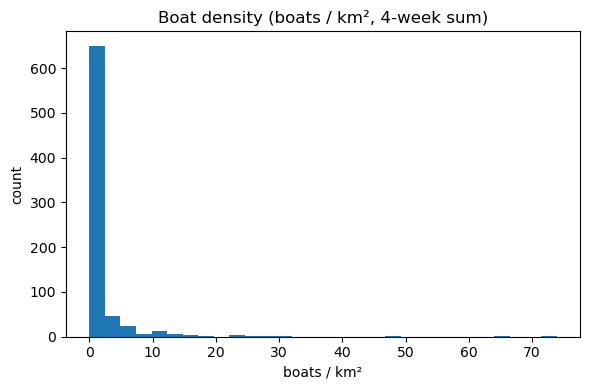

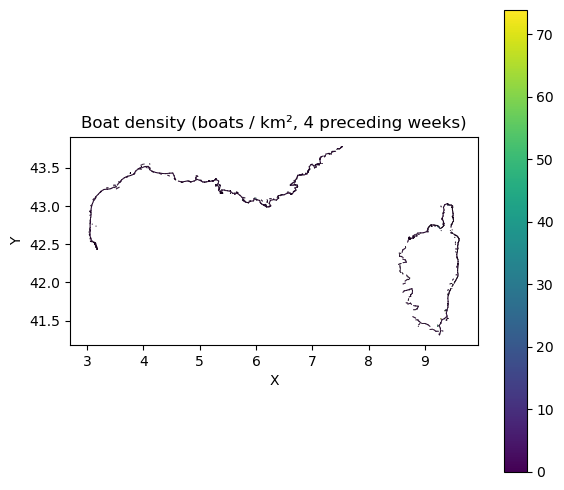


Written GeoPackage: ./data/processed_data/predictors//Boats/mtdt_7_boats_month_ALL.gpkg


In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1. Load extracted table and polygons
# ----------------------------------------------------------
results_csv = out
polygons_gpkg = "./data/processed_data/Mtdt/mtdt_7.gpkg"

df = pd.read_csv(results_csv)
gdf = gpd.read_file(polygons_gpkg)

# ----------------------------------------------------------
# 2. Merge using "replicates" (must exist in both)
# ----------------------------------------------------------
merged = gdf.merge(df, on="replicates", how="left")

# Keep only rows where density exists
vals = merged[["Boat_density_month"]].dropna()

print("Valid polygons:", len(vals))

# ----------------------------------------------------------
# 3. Basic statistics
# ----------------------------------------------------------
print("\n=== Basic Stats (density, boats / km² over 4 weeks) ===")

col = "Boat_density_month"
print(f"\n{col}:")
print("  min:", vals[col].min())
print("  max:", vals[col].max())
print("  mean:", vals[col].mean())
print("  std:", vals[col].std())

# ----------------------------------------------------------
# 4. Plot distribution (histogram)
# ----------------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(vals[col], bins=30)
plt.title("Boat density (boats / km², 4-week sum)")
plt.xlabel("boats / km²")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 5. Map: polygons colored by Boat_weekly_month_density
# ----------------------------------------------------------
gmap = merged.dropna(subset=[col])

fig, ax = plt.subplots(figsize=(6,5))
gmap.plot(
    column=col,
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
)
ax.set_title("Boat density (boats / km², 4 preceding weeks)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 6. Export merged result to GPKG (optional)
# ----------------------------------------------------------

out_gpkg = "./data/processed_data/predictors//Boats/mtdt_7_boats_month_ALL.gpkg"
merged.to_file(out_gpkg, driver="GPKG")

print(f"\nWritten GeoPackage: {out_gpkg}")

